# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow_datasets as tfds
import tensorflow as tf
from cv2 import cv2
from skimage import feature
from sklearn import neighbors


# Retrieve Dataset

In [2]:
from preprocess import retrieve_dataset, preprocess, to_np

(train_ds_raw, test_ds_raw), metadata = retrieve_dataset(should_shuffle_files=True)

train_ds = preprocess(train_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 0,
  'is_grayscale': False, 
  'is_downsample64': False,
  'is_downsample128': False, 
  'is_normalize': False,
})

test_ds = preprocess(test_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 0,
  'is_grayscale': False, 
  'is_downsample64': False, 
  'is_downsample128': False, 
  'is_normalize': False,
})

def count_class(counts, batch):
    labels = batch[1]
    for i in range(9):
        cc = tf.cast(labels == i, tf.int32)
        counts[i] += tf.reduce_sum(cc)
    return counts

initial_state = dict((i, 0) for i in range(9))
counts = train_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for train dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

initial_state = dict((i, 0) for i in range(9))
counts = test_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for test dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

Class breakdown for train dataset:
[(0, 891), (1, 853), (2, 818), (3, 819), (4, 845), (5, 809), (6, 856), (7, 781), (8, 834)]
Class breakdown for test dataset:
[(0, 234), (1, 211), (2, 213), (3, 203), (4, 217), (5, 200), (6, 218), (7, 235), (8, 216)]


# Extract X_train, Y_train, X_test, Y_test

In [3]:
train_ds_numpy = to_np(train_ds)
test_ds_numpy = to_np(test_ds)

In [4]:
X_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

# Visualize Preprocessed Dataset

Length of X_train: 7506
Length of X_test: 1947


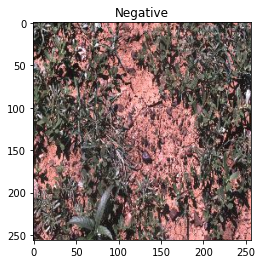

In [5]:
from visualize import visualize, compare

visualize(X_train[0], y_train[0], metadata)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

# Perform Transfer Learning

In [6]:
from transfer_learning import init_conv_base, extract_features
conv_base = init_conv_base(X_train[0])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [7]:
train_features, train_labels = extract_features(conv_base, X_train, y_train)  # Agree with our small dataset size
test_features, test_labels = extract_features(conv_base, X_test, y_test)

# Flatten To Feed into Logistic regression

In [8]:
X_train_flatten = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test_flatten = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608
print(X_train_flatten[0][0:8])
print(train_features[0][0,0,7])

(7506,)
feature size now: (256, 256, 3)
[0.06870419 0.         0.         0.29906398 0.16022553 0.
 0.         0.        ]
0.0


# Test Model with K Fold Validation

In [9]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import kfold_cross_validation, get_precision_scores, get_roc_auc_curve, visualize_roc_auc_curve, train_model

In [12]:
Cs = [1.0]
k = 5
accuracies = []

for C in Cs:
  accuracies.append(kfold_cross_validation(k, X_train_flatten, y_train, 'logistic', {'max_iter': 3000, 'C': C}))

highest_index = np.argmax(accuracies)
best_C = Cs[highest_index]

print(f'Best C: {best_C}')

Running 5-fold cross validation for logistic with {'max_iter': 3000, 'C': 1.0}
Split accuracy: 0.711051930758988
Split accuracy: 0.7068620919387075
Split accuracy: 0.7121918720852765
Split accuracy: 0.7015323117921386
Split accuracy: 0.7255163224516988
Completed 5-fold cross validation for logistic with {'max_iter': 3000, 'C': 1.0}
Obtained average accuracy of: 0.7114309058053618

Best C: 1.0


In [13]:
model = train_model('logistic', {'max_iter': 3000, 'C': best_C}, X_train_flatten, y_train, True)

print(get_precision_scores(model, X_test_flatten, y_test))

Saved final model to file: models/logistic_max_iter3000C10_final.pickle

{'accuracy': 0.7170005136106831, 'macro_avg': 0.714420626712509, 'f1_score_macro': 0.7164070110855401, 'micro_avg': 0.7170005136106831, 'f1_score_micro': 0.7170005136106831, 'roc_auc_score': 0.9517199798567653}


# Evaluation and Visualization

In [14]:
(fpr, tpr, roc_auc) = get_roc_auc_curve(model, X_train_flatten, y_train, X_test_flatten, y_test, {'is_svm': False})

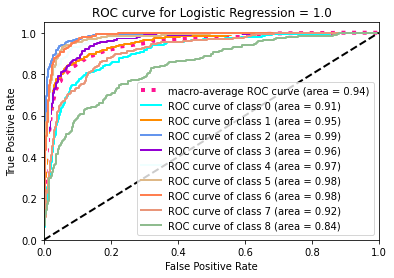

In [15]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import visualize_roc_auc_curve

title = f'ROC curve for Logistic Regression = {str(best_C)}'
visualize_roc_auc_curve(title, fpr, tpr, roc_auc, len(np.unique(y_test)))

# Pseudo Grad CAM For Logistic Regression
We treat the .coef_ attribute of the sklearn Logistic Regression model as the derivative  
of predicted label to the feature after extraction. Then we compute the important weight  
of each feature map and constuct the heap map of different input images in the similar way  
as the Grad_CAM procedure.

In [16]:
def sudo_gradcam(clf, pred, feature_map_size):
  coefs = clf.coef_[pred]
  result = np.zeros(int(coefs.size/feature_map_size))
  index = 0
  for coef in coefs:
    result[index] += coef
    index += 1
    if (index == int(coefs.size/feature_map_size)):
      index = 0
  return np.array(result)

2 4.0


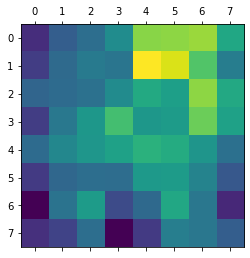

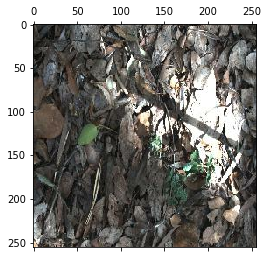

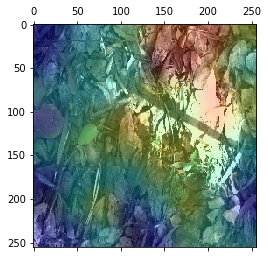

In [52]:
feature_map_size = 8*8
feature_map_num = 512

imp_w = []
for k in range(9):
  imp_w.append(sudo_gradcam(model, k, feature_map_size))
  
# take test case=img_index as example.
img_index = 121
pred = int(model.predict(X_test_flatten[img_index].reshape(1, -1))[0])
heatmap = imp_w[pred][0] * test_features[img_index,:,:,0]
for i in range(1, feature_map_num): # 
  heatmap += imp_w[pred][i] * test_features[img_index,:,:,i]
  
heatmap = tf.nn.relu(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
print(pred, y_test[img_index])
plt.matshow(heatmap)

# Superimpose the heatmap on original image
# Refers to : https://github.com/keras-team/keras-io/blob/master/examples/vision/grad_cam.py
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((256, 256))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

alpha = 0.4
superimposed_img = jet_heatmap * alpha + X_test[img_index]
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
plt.matshow(X_test[img_index])
plt.matshow(superimposed_img)

### Note: 

Because the feature extractor (transfer learning) did not be trained according our data,  
some features unrelated to labels but common within a certain label (ground, shadow, etc.) might be extracted and treated as important in the Logistic Regression process.  
This might cause some images which belong to other labels be misclassified because they are similar in these unrelated features.